<a href="https://colab.research.google.com/github/esfandiaryfard/machine-learning/blob/main/dcgan_with_minibach_discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import PIL.Image
import io
import os
import IPython.display
import numpy as np
from tqdm.notebook import tqdm

In [73]:
def showarray(a, fmt='png'):
    a = (a - a.min())
    a = a /a.max()
    a = np.uint8(a*255)
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [74]:
# Set parameters
dataroot = 'dataset_folder'
outf = "output"
batch_size = 4
num_workers = 2
image_size = 64 # Size of the input/output image
nc = 3 # Color channels 
nz = 100 # Length of the noise vector
ngf = 64 # Initial generator feature maps
ndf = 64 # Initial discriminator feature maps
num_epochs = 3
lr = 0.0002
beta1 = 0.5 # Optimizer parameter
saveCheck = 1 # Save checkpoint every # epochs
nb=64
n_C=8

In [75]:
try:
    os.makedirs(outf)
except OSError:
  pass   

In [76]:
cudnn.benchmark = True

In [77]:
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [78]:
# Define a transformation
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                              
])

# Load CIFAR-10 dataset
dataset= dset.CIFAR10(root=dataroot, download=True, transform=train_transform)

Files already downloaded and verified


In [79]:
# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)

In [80]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # For every Conv Layer in a model
        # Initializes weights with values from a normal distribution
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [81]:
#Generator definition
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            #nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [82]:
# Create the Generator 
netG = _netG()
# Initialize weights
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [83]:
import torch
import torch.nn as nn

from torch.autograd import Variable
from torch.nn.parameter import Parameter

class MiniBatchDiscrimination(nn.Module):
	def __init__(self, A, B, C, batch_size):
		super(MiniBatchDiscrimination, self).__init__()
		self.feat_num = A
		self.out_size = B
		self.row_size = C
		self.N = batch_size
		self.T = Parameter(torch.Tensor(A,B,C))
		self.reset_parameters()

	def forward(self, x):
		# Output matrices after matrix multiplication
		M = x.mm(self.T.view(self.feat_num,self.out_size*self.row_size)).view(-1,self.out_size,self.row_size)
		out = Variable(torch.zeros(self.N,self.out_size))
		for k in range(self.N): # Not happy about this 'for' loop, but this is the best we could do using PyTorch IMO
			c = torch.exp(-torch.sum(torch.abs(M[k,:]-M),2)) # exp(-L1 Norm of Rows difference)
			if k != 0 and k != self.N -1: 
				out[k,:] = torch.sum(c[0:k,:],0) + torch.sum(c[k:-1,:],0)
			else:
				if k == 0:
					out[k,:] = torch.sum(c[1:,:],0)
				else:
					out[k,:] = torch.sum(c[0:self.N-1],0)
		return out

	def reset_parameters(self):
		stddev = 1/self.feat_num
		self.T.data.uniform_(stddev)

In [84]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
        )
        self.mbd = MiniBatchDiscrimination(ndf * 8 * 4 * 4, 64, 50, batch_size)
        self.lin = nn.Sequential(
            nn.Linear(ndf * 8 * 4 * 4 + 64, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        output = self.main(input)
        mbd_out = self.mbd(output.view(-1, ndf * 8 * 4 * 4)).to(dev)
        combined = torch.cat((output.view(-1, ndf * 8 * 4 * 4), mbd_out), dim=1)
        return self.lin(combined).view(-1, 1).squeeze(1)


In [85]:
# Create the Discriminator
netD = _netD()
# Initialize weights
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (mbd): MiniBatchDiscrimination()
  (lin): Sequential(
    (0): Linear(in_features=8256, out_features=1, bias=True)
    (1): Sigmoi

In [86]:
# Define a Loss
criterion = nn.BCELoss()

In [87]:
# Define optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [88]:
# A batch of latent vectors; we will use it to visualize the progression of the generator
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).to(dev)

real_label = 1
fake_label = 0

In [89]:
# Move to cuda
netD.to(dev)
netG.to(dev) 

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#Training

The training is split in two main parts: part 1 updates the Discriminator, part 2 updates the Generator.

## Part 1 - Update the Discriminator
First, we construct a batch of real samples from training set, forward pass through the Discriminator, calculate the loss, then calculate the gradients. 
Secondly, we construct a batch of *fake* sample using the Generator, forward pass through the Discriminator, calculate the loss, and accumulate gradients with a backward pass.
Now, with gradients accumulated from both real and fake batches, we call `optmizerD.step()` 

## Part 2 - Update the Generator
We classify the Generator output with the Discriminator, compute the loss of G *using the real labels*, compute the gradients with a backward pass, and finally update the Generator parameters with `optimizerG.step()`

In [90]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
transform_fid = transforms.Compose([
    transforms.Resize(image_size)                            
])
dataset_fid= dset.CIFAR10(root=dataroot, download=True, transform=transform_fid, train=False)
os.makedirs('cifar10_images')
for idx in tqdm(range(len(dataset_fid))):
  img, label = dataset_fid.__getitem__(idx)
  img.save(f"cifar10_images/{idx}.png")

Files already downloaded and verified


FileExistsError: ignored

In [ ]:
from pytorch_fid.fid_score import calculate_fid_given_paths
import uuid
import shutil

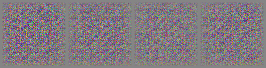

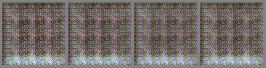

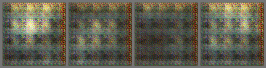

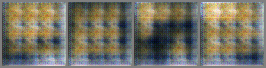

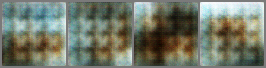

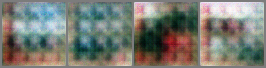

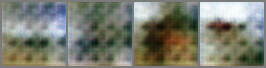

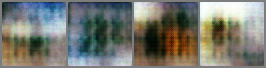

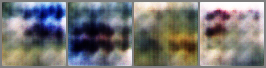

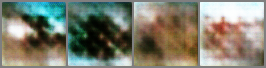

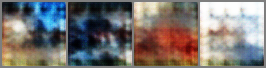

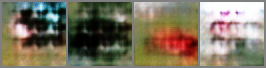

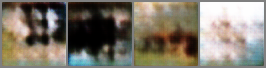

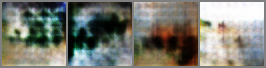

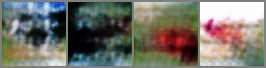

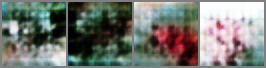

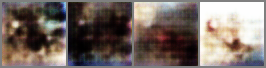

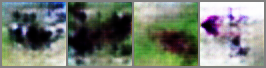

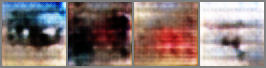

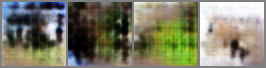

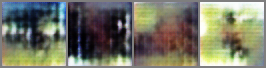

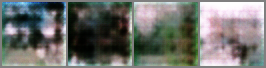

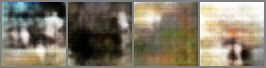

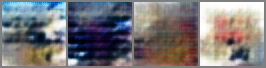

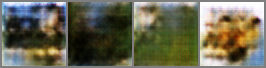

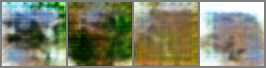

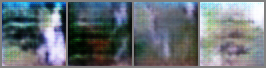

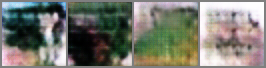

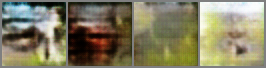

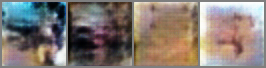

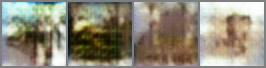

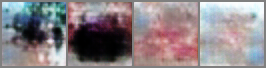

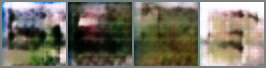

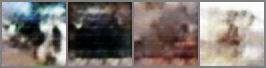

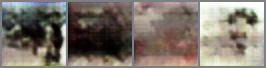

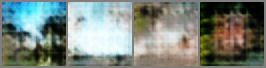

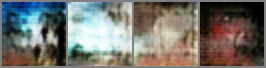

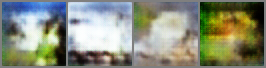

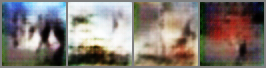

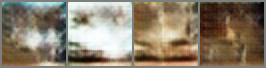

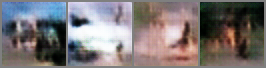

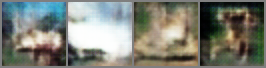

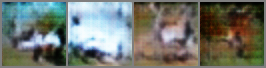

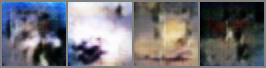

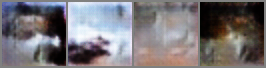

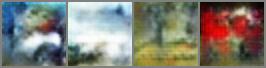

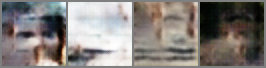

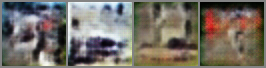

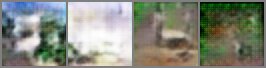

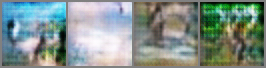

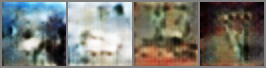

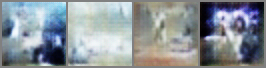

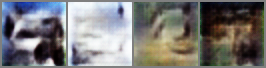

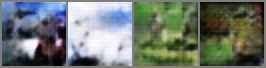

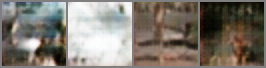

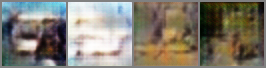

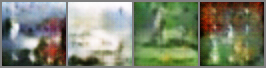

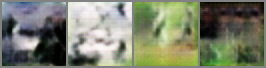

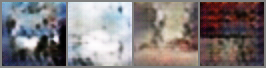

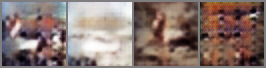

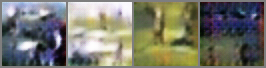

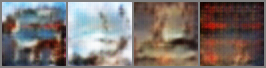

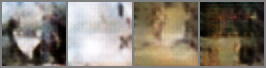

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:36<00:00,  4.35it/s]


Epoch 0: FID=178.3782 DR=0.5046, DF=0.4500, G=2.5721


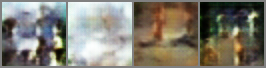

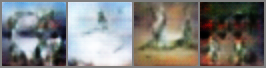

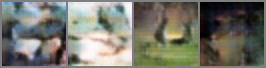

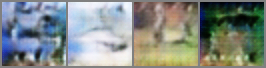

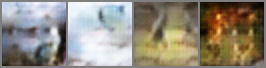

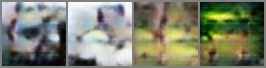

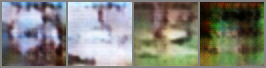

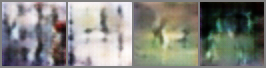

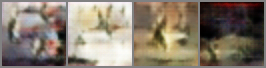

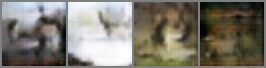

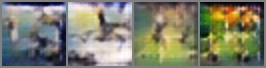

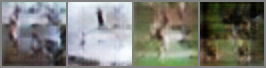

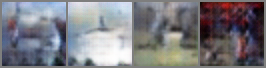

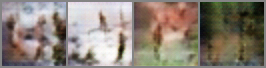

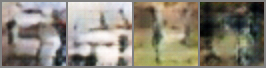

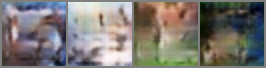

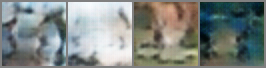

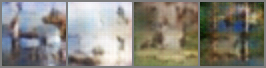

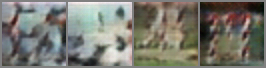

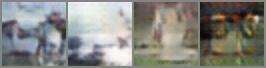

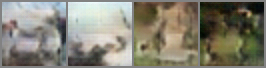

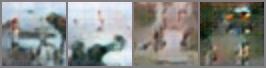

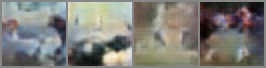

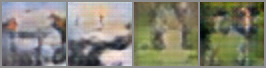

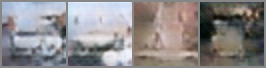

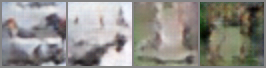

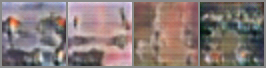

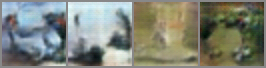

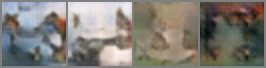

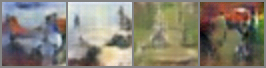

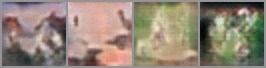

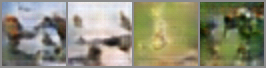

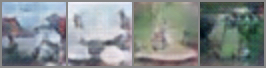

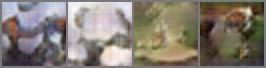

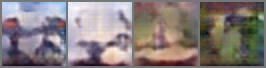

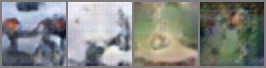

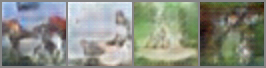

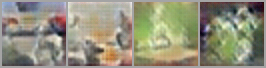

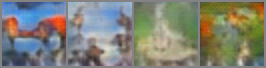

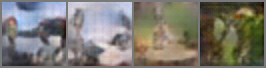

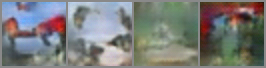

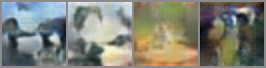

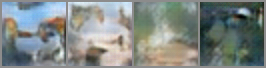

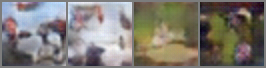

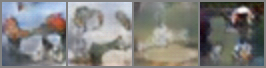

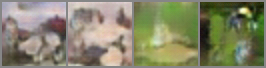

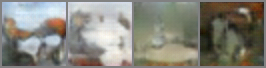

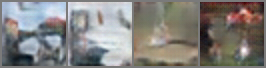

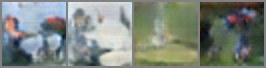

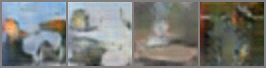

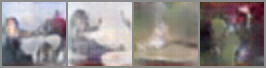

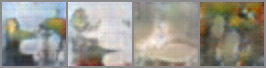

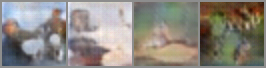

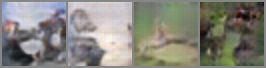

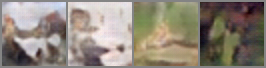

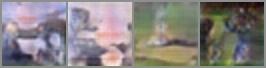

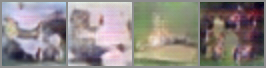

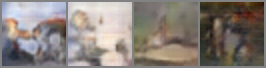

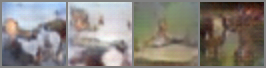

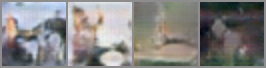

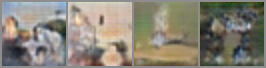

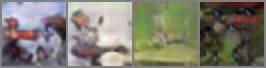

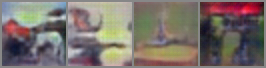

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:36<00:00,  4.34it/s]


Epoch 1: FID=154.1712 DR=0.3749, DF=0.3115, G=3.1649


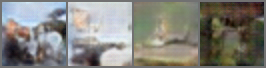

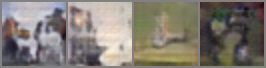

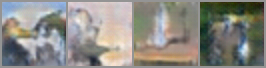

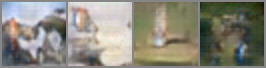

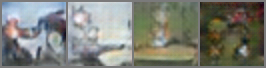

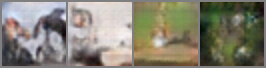

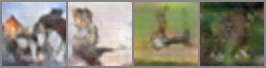

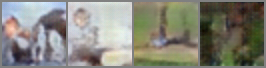

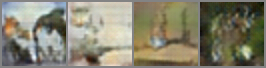

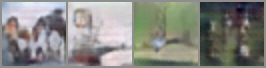

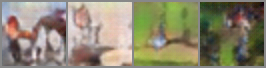

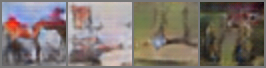

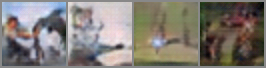

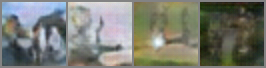

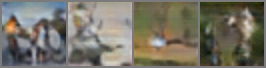

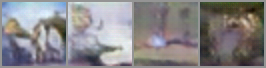

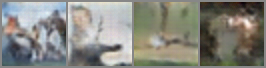

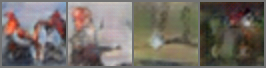

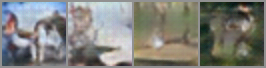

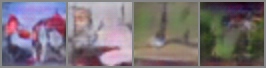

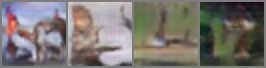

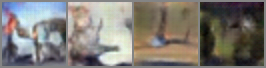

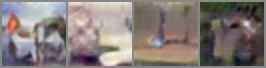

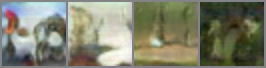

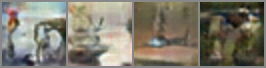

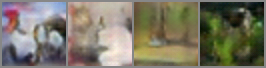

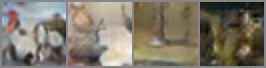

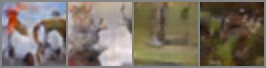

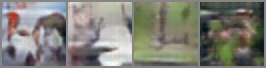

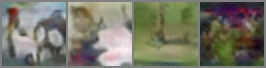

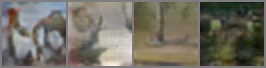

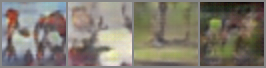

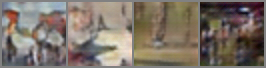

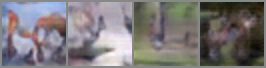

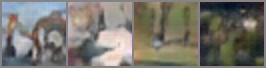

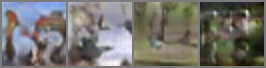

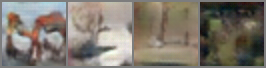

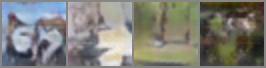

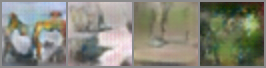

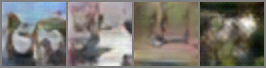

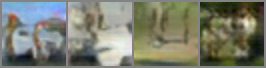

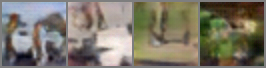

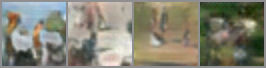

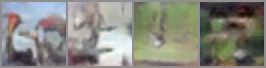

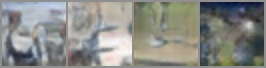

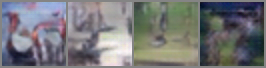

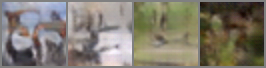

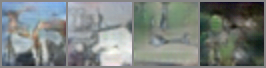

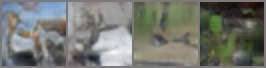

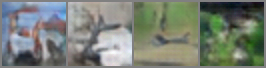

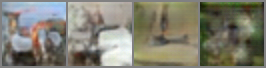

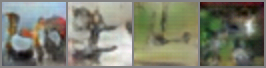

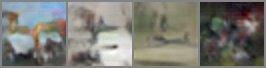

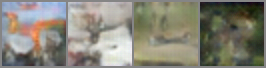

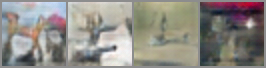

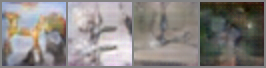

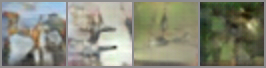

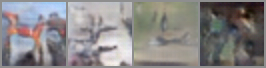

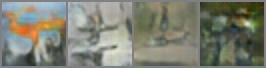

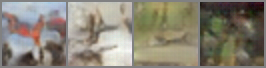

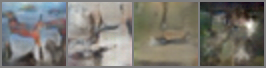

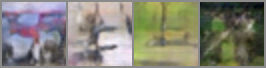

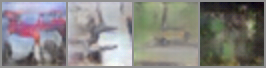

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:36<00:00,  4.35it/s]


Epoch 2: FID=101.7632 DR=0.3146, DF=0.2739, G=3.7238


In [92]:
netD.train()
netG.train()
all_fid = []
for epoch in range(num_epochs):
    # Loss measures
    sum_g_loss = 0; num_g_loss = 0
    sum_d_real_loss = 0; num_d_real_loss = 0
    sum_d_fake_loss = 0; num_d_fake_loss = 0

    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ### Train Discriminator with real
        # Reset discriminator gradients
        netD.zero_grad()
        
        # Real Data
        real_cpu = data[0].to(dev)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=dev)
        # Forward (discriminator, real)
        output = netD(real_cpu)
        # Compute loss (discriminator, real)
        errD_real = criterion(output, label)
        sum_d_real_loss += errD_real.item()
        num_d_real_loss += 1
        # Backward (discriminator, real)
        errD_real.backward()

        ### Train Discriminator with fake, using the Generator also. 
        noise = torch.randn(batch_size, nz, 1, 1, device=dev)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        # Compute loss (discriminator, fake)
        errD_fake = criterion(output, label)
        sum_d_fake_loss += errD_fake.item()
        num_d_fake_loss += 1
        # Backward (discriminator, fake)
        errD_fake.backward()
        # Update discriminator
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # Reset generator gradients
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        # Compute loss (generator)
        errG = criterion(output, label.float())
        sum_g_loss += errG.item()
        num_g_loss += 1
        # Backward (generator)
        errG.backward()
        #update generator
        optimizerG.step()

        if i % 200 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
            grid_img = vutils.make_grid(fake.cpu().detach(), nrow=8)
            showarray(grid_img.permute(1, 2, 0))


    # Print
    avg_d_real_loss = sum_d_real_loss/num_d_real_loss
    avg_d_fake_loss = sum_d_fake_loss/num_d_fake_loss
    avg_g_loss = sum_g_loss/num_g_loss
    #FID
    os.makedirs('tmp')
    for _ in tqdm(range(20)):
      with torch.no_grad():
        noise = torch.randn(500, nz, 1, 1, device=dev)
        fake_imgs = netG(noise)
      for idx in range(fake_imgs.shape[0]):
        fake_img = fake_imgs[idx]
        vutils.save_image(fake_img,f"tmp/{str(uuid.uuid4())}.png",normalize=True)
    fid = calculate_fid_given_paths(['cifar10_images','tmp'],dims=2048, device = 'cuda',batch_size=64)
    all_fid.append(fid)
    shutil.rmtree('tmp')
    print(f"Epoch {epoch}: FID={fid:.4f} DR={avg_d_real_loss:.4f}, DF={avg_d_fake_loss:.4f}, G={avg_g_loss:.4f}")


    # do checkpointing
    if epoch % saveCheck == 0:
        torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
        torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

In [ ]:
import matplotlib
matplotlib.pyplot.plot(all_fid)